In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Lambda, AveragePooling2D, Softmax, ReLU, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
from math import floor,inf
from sklearn.utils import shuffle

In [2]:
data_folder = 'BBCI competition IV 2a'  ###location of .mat files for each subject, change file path if running notebook from...
                                        ###...different directory to data folder
subject_files = os.listdir(data_folder)

In [3]:
###Unfiltered .mat files for each subject, E = validation/evaluation set, T = Training set
subject_files

['A01E.mat',
 'A01T.mat',
 'A02E.mat',
 'A02T.mat',
 'A03E.mat',
 'A03T.mat',
 'A04E.mat',
 'A04T.mat',
 'A05E.mat',
 'A05T.mat',
 'A06E.mat',
 'A06T.mat',
 'A07E.mat',
 'A07T.mat',
 'A08E.mat',
 'A08T.mat',
 'A09E.mat',
 'A09T.mat']

In [4]:
####Create dataset of only the 4s in the trials where MI was being performed.
def create_4sec_data(subject,dataset):
    data_folder = 'BBCI competition IV 2a'
    file = 'A0' + str(subject) + dataset[0] + '.mat'
    file_path = os.path.join(data_folder, file )
    print(file_path)
    data = sio.loadmat(file_path)['data']
    x=[]
    y=[]
    if file == 'A04T.mat':   ###Subject 4 had some unused missing data in training set
        lower_lim = 1
        upper_lim = 7
    else:
        lower_lim = 3
        upper_lim = 9
    for s in range(lower_lim, upper_lim):
        eeg = pd.DataFrame(np.transpose(data[0,s][0,0][0])[:22])
        cues = data[0,s][0,0][1]
        mi = data[0,s][0,0][2]
        for i in range(48):
            start = cues[i][0] + 500
            end = start + 1000
            mi_data = eeg.iloc[:,start:end]
            x.append(np.array(mi_data))
            if mi[i][0] == 3:
                y.append(0)
            elif mi[i][0] == 4:
                y.append(3)
            else:
                y.append(mi[i][0])
            
    return np.array(x), np.array(y)

In [5]:
###Function to segment and filter 4s data into 2s segments
def filt_and_seg(x_4sec, y_4sec, samples, overlap):
    unique = floor((1-overlap)*samples)
    b,a = signal.butter(2, Wn = [48,52], btype = 'bandstop', fs = 250)
    d,c = signal.butter(2, Wn = [4,38], btype = 'bandpass', fs = 250)
    x=[]
    y=[]
    count = 0
    for trial in x_4sec:
        data = trial
        label = y_4sec[count]
        for div in range(int(data.size//(data.shape[0]*unique))):
            if div*unique +samples <= data.size/data.shape[0]:
                array = np.ndarray((22,samples))
                for i in range(22):
                    notch_filt = signal.filtfilt(b,a, data[i][div*unique:div*unique + samples], padtype='even')
                    bp_filt = signal.filtfilt(d,c, notch_filt, padtype='even')
                    array[i] = bp_filt
                x.append(array)
                y.append(label)
        count+=1
    x=np.array(x)
    x=x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
    x, y = shuffle(x,y, random_state=42)
    return x,y
        

In [6]:
###Function to build shallow CNNs
def build_model():
    shallow = True

    ####  MODEL BUILDER  ####

    model = Sequential()
    if shallow:
        model.add(Conv2D(filters=40, kernel_size=(1,25), input_shape=(x_train.shape[1],x_train.shape[2],1))) #, activation = 'relu'))
        model.add(Conv2D(filters=40, kernel_size=(22,1), activation = 'elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))
        model.add(Lambda(lambda x: x**2))
        model.add(AveragePooling2D(pool_size=(1,75),strides=15))

        model.add(Lambda(lambda x: tf.math.log(tf.clip_by_value(x, 1e-6, inf))))

        model.add(Dropout(0.5))

        '''model.add(Conv2D(filters=4, kernel_size=(1,69))) #, activation = 'relu'))       

        model.add(Softmax())

        model.add(Lambda(lambda x: tf.squeeze(x, [1,2])))'''  #equivalent to flattening which was used instead
    else:    #Deep CNN from Schirrmeister, not used
        model.add(Conv2D(filters=25, kernel_size=(1,10), input_shape=(x_train.shape[1],x_train.shape[2],1))) #, activation = 'relu'))
        model.add(Conv2D(filters=25, kernel_size=(13,1), activation = 'elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))

        model.add(MaxPool2D(pool_size=(1,3),strides=3))
        model.add(Dropout(0.5))
        model.add(Conv2D(filters=50, kernel_size=(1,10), activation='elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))

        model.add(MaxPool2D(pool_size=(1,3),strides=3))
        model.add(Dropout(0.5))
        model.add(Conv2D(filters=100, kernel_size=(1,10), activation='elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))

        model.add(MaxPool2D(pool_size=(1,3),strides=3))
        model.add(Dropout(0.5))
        model.add(Conv2D(filters=200, kernel_size=(1,10), activation='elu'))
        model.add(BatchNormalization(momentum=0.1, epsilon = 1e-05))
        model.add(MaxPool2D(pool_size=(1,3),strides=3))



    model.add(Flatten())

    model.add(Dense(4, activation = 'softmax'))

    act_fn = 'softmax'
    loss_fn = 'categorical_crossentropy'

    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss = loss_fn, optimizer=adam, metrics=['accuracy'], )  # other metrics at keras.io/metrics

    model.summary()

    
    return model
    

{'1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': []}
BBCI competition IV 2a\A01T.mat
BBCI competition IV 2a\A01E.mat
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 476, 40)        35240     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 476, 40)        160       
_________________________________________________________________
lambda_10 (Lambda)           (None, 1, 476, 40)        0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 1, 27, 40)         0         
_________________________________________________________________
lambda_11 (Lambda)           (None, 1, 2

Epoch 47/400
99/99 [==============================] - 1s 14ms/step - loss: 0.1388 - accuracy: 0.9612 - val_loss: 0.6388 - val_accuracy: 0.7560
Epoch 48/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1262 - accuracy: 0.9669 - val_loss: 0.6680 - val_accuracy: 0.7390
Epoch 49/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1256 - accuracy: 0.9628 - val_loss: 0.5943 - val_accuracy: 0.7683
Epoch 50/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1135 - accuracy: 0.9684 - val_loss: 0.6497 - val_accuracy: 0.7566
Epoch 51/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1140 - accuracy: 0.9713 - val_loss: 0.6350 - val_accuracy: 0.7551
Epoch 52/400
99/99 [==============================] - 1s 13ms/step - loss: 0.0985 - accuracy: 0.9798 - val_loss: 0.6479 - val_accuracy: 0.7525
Epoch 53/400
99/99 [==============================] - 1s 13ms/step - loss: 0.1041 - accuracy: 0.9719 - val_loss: 0.6697 - val_accuracy: 0.7525

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.70      0.68      0.69       792
           1       0.83      0.80      0.81       792
           2       0.85      0.84      0.85       792
           3       0.69      0.74      0.71       792

    accuracy                           0.77      3168
   macro avg       0.77      0.77      0.77      3168
weighted avg       0.77      0.77      0.77      3168

[[542  18  14 218]
 [ 29 630 100  33]
 [ 28  82 665  17]
 [177  27   1 587]]
99/99 [==============================] - 1s 6ms/step - loss: 0.5782 - accuracy: 0.7652
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 476, 40)        35240     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.72      0.73      0.72       792
           1       0.84      0.80      0.82       792
           2       0.82      0.91      0.86       792
           3       0.74      0.69      0.71       792

    accuracy                           0.78      3168
   macro avg       0.78      0.78      0.78      3168
weighted avg       0.78      0.78      0.78      3168

[[577  34  22 159]
 [ 13 632 130  17]
 [ 12  45 718  17]
 [199  45   4 544]]
99/99 [==============================] - 0s 4ms/step - loss: 0.5569 - accuracy: 0.7800
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 476, 40)        35240     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.65      0.63      0.64       792
           1       0.82      0.84      0.83       792
           2       0.86      0.81      0.84       792
           3       0.66      0.70      0.68       792

    accuracy                           0.75      3168
   macro avg       0.75      0.75      0.75      3168
weighted avg       0.75      0.75      0.75      3168

[[496  27  28 241]
 [ 25 667  73  27]
 [ 27 105 644  16]
 [215  16   4 557]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5820 - accuracy: 0.7462
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 1, 476, 40)        35240     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.70      0.78      0.74       792
           1       0.76      0.87      0.81       792
           2       0.87      0.79      0.83       792
           3       0.75      0.62      0.68       792

    accuracy                           0.77      3168
   macro avg       0.77      0.77      0.77      3168
weighted avg       0.77      0.77      0.77      3168

[[619  33  16 124]
 [  8 688  76  20]
 [ 16 130 628  18]
 [238  53   6 495]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5814 - accuracy: 0.7670
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 476, 40)        35240     
_________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.69      0.73      0.71       792
           1       0.83      0.80      0.81       792
           2       0.85      0.83      0.84       792
           3       0.72      0.72      0.72       792

    accuracy                           0.77      3168
   macro avg       0.77      0.77      0.77      3168
weighted avg       0.77      0.77      0.77      3168

[[579  25  12 176]
 [ 29 633 102  28]
 [ 23  94 659  16]
 [207  13   4 568]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5427 - accuracy: 0.7699
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.73      0.81      0.77       792
           1       0.80      0.84      0.82       792
           2       0.86      0.79      0.83       792
           3       0.77      0.71      0.74       792

    accuracy                           0.79      3168
   macro avg       0.79      0.79      0.79      3168
weighted avg       0.79      0.79      0.79      3168

[[643  17  13 119]
 [ 20 663  82  27]
 [ 15 133 626  18]
 [205  19   4 564]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5519 - accuracy: 0.7879
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.72      0.69      0.71       792
           1       0.80      0.83      0.82       792
           2       0.84      0.83      0.84       792
           3       0.73      0.74      0.74       792

    accuracy                           0.77      3168
   macro avg       0.77      0.77      0.77      3168
weighted avg       0.77      0.77      0.77      3168

[[550  27  26 189]
 [ 26 655  94  17]
 [ 17 107 657  11]
 [174  26   4 588]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5294 - accuracy: 0.7734
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.70      0.76      0.73       792
           1       0.81      0.85      0.83       792
           2       0.86      0.80      0.83       792
           3       0.73      0.68      0.71       792

    accuracy                           0.77      3168
   macro avg       0.78      0.77      0.77      3168
weighted avg       0.78      0.77      0.77      3168

[[603  15  20 154]
 [ 18 675  78  21]
 [ 22 116 633  21]
 [223  25   2 542]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5696 - accuracy: 0.7743
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.65      0.78      0.71       792
           1       0.82      0.84      0.83       792
           2       0.88      0.80      0.84       792
           3       0.73      0.65      0.69       792

    accuracy                           0.77      3168
   macro avg       0.77      0.77      0.77      3168
weighted avg       0.77      0.77      0.77      3168

[[620  13  10 149]
 [ 33 662  73  24]
 [ 37 109 631  15]
 [258  19   2 513]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5479 - accuracy: 0.7658
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.69      0.70      0.70       792
           1       0.80      0.78      0.79       792
           2       0.80      0.82      0.81       792
           3       0.71      0.70      0.71       792

    accuracy                           0.75      3168
   macro avg       0.75      0.75      0.75      3168
weighted avg       0.75      0.75      0.75      3168

[[558  26  25 183]
 [ 21 617 125  29]
 [ 21 110 646  15]
 [210  18   9 555]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5811 - accuracy: 0.7500
BBCI competition IV 2a\A02T.mat
BBCI competition IV 2a\A02E.mat
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 476, 40)   

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.56      0.76      0.64       792
           1       0.32      0.27      0.29       792
           2       0.37      0.39      0.38       792
           3       0.49      0.34      0.41       792

    accuracy                           0.44      3168
   macro avg       0.43      0.44      0.43      3168
weighted avg       0.43      0.44      0.43      3168

[[605  42  91  54]
 [199 215 250 128]
 [138 246 310  98]
 [146 179 194 273]]
99/99 [==============================] - 1s 6ms/step - loss: 1.2863 - accuracy: 0.4429
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.63      0.71      0.67       792
           1       0.35      0.32      0.34       792
           2       0.41      0.35      0.38       792
           3       0.48      0.52      0.50       792

    accuracy                           0.48      3168
   macro avg       0.47      0.48      0.47      3168
weighted avg       0.47      0.48      0.47      3168

[[565  56  67 104]
 [136 256 213 187]
 [ 86 263 280 163]
 [112 152 117 411]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2958 - accuracy: 0.4773
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.56      0.70      0.62       792
           1       0.33      0.41      0.37       792
           2       0.37      0.24      0.29       792
           3       0.44      0.39      0.42       792

    accuracy                           0.43      3168
   macro avg       0.43      0.43      0.42      3168
weighted avg       0.43      0.43      0.42      3168

[[553 105  50  84]
 [164 324 142 162]
 [130 321 188 153]
 [137 219 124 312]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2884 - accuracy: 0.4347
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.61      0.73      0.66       792
           1       0.34      0.26      0.29       792
           2       0.39      0.41      0.40       792
           3       0.46      0.45      0.45       792

    accuracy                           0.46      3168
   macro avg       0.45      0.46      0.45      3168
weighted avg       0.45      0.46      0.45      3168

[[582  44  83  83]
 [165 204 243 180]
 [110 198 323 161]
 [103 153 180 356]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2767 - accuracy: 0.4624
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.45      0.75      0.56       792
           1       0.30      0.34      0.32       792
           2       0.36      0.20      0.26       792
           3       0.40      0.25      0.31       792

    accuracy                           0.39      3168
   macro avg       0.38      0.39      0.36      3168
weighted avg       0.38      0.39      0.36      3168

[[597  97  36  62]
 [294 271 121 106]
 [214 294 158 126]
 [219 255 120 198]]
99/99 [==============================] - 0s 4ms/step - loss: 1.3299 - accuracy: 0.3864
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.51      0.67      0.58       792
           1       0.28      0.30      0.29       792
           2       0.39      0.30      0.34       792
           3       0.35      0.30      0.32       792

    accuracy                           0.39      3168
   macro avg       0.38      0.39      0.38      3168
weighted avg       0.38      0.39      0.38      3168

[[532  81  83  96]
 [236 238 150 168]
 [121 268 235 168]
 [148 271 138 235]]
99/99 [==============================] - 1s 7ms/step - loss: 1.2999 - accuracy: 0.3914
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.58      0.66      0.62       792
           1       0.34      0.28      0.31       792
           2       0.35      0.46      0.40       792
           3       0.47      0.33      0.39       792

    accuracy                           0.44      3168
   macro avg       0.44      0.44      0.43      3168
weighted avg       0.44      0.44      0.43      3168

[[523  65 140  64]
 [147 225 308 112]
 [ 96 211 368 117]
 [129 163 237 263]]
99/99 [==============================] - 0s 5ms/step - loss: 1.3247 - accuracy: 0.4353
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.58      0.73      0.65       792
           1       0.38      0.34      0.36       792
           2       0.44      0.38      0.41       792
           3       0.43      0.43      0.43       792

    accuracy                           0.47      3168
   macro avg       0.46      0.47      0.46      3168
weighted avg       0.46      0.47      0.46      3168

[[579  56  51 106]
 [158 268 188 178]
 [113 219 302 158]
 [144 159 150 339]]
99/99 [==============================] - 0s 3ms/step - loss: 1.3170 - accuracy: 0.4697
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.80      0.63       792
           1       0.31      0.36      0.33       792
           2       0.44      0.24      0.31       792
           3       0.44      0.33      0.37       792

    accuracy                           0.43      3168
   macro avg       0.43      0.43      0.41      3168
weighted avg       0.43      0.43      0.41      3168

[[635  65  34  58]
 [255 288 116 133]
 [165 296 191 140]
 [154 290  89 259]]
99/99 [==============================] - 0s 3ms/step - loss: 1.3135 - accuracy: 0.4334
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.68      0.59       792
           1       0.34      0.30      0.32       792
           2       0.39      0.27      0.32       792
           3       0.38      0.44      0.41       792

    accuracy                           0.42      3168
   macro avg       0.41      0.42      0.41      3168
weighted avg       0.41      0.42      0.41      3168

[[536  72  61 123]
 [202 237 143 210]
 [146 203 212 231]
 [130 188 127 347]]
99/99 [==============================] - 1s 5ms/step - loss: 1.2635 - accuracy: 0.4205
BBCI competition IV 2a\A03T.mat
BBCI competition IV 2a\A03E.mat
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 1, 476, 40)   

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.64      0.72       792
           1       0.89      0.81      0.85       792
           2       0.83      0.97      0.90       792
           3       0.71      0.82      0.76       792

    accuracy                           0.81      3168
   macro avg       0.82      0.81      0.81      3168
weighted avg       0.82      0.81      0.81      3168

[[504  34  63 191]
 [ 20 641  67  64]
 [  2  12 769   9]
 [ 81  36  23 652]]
99/99 [==============================] - 0s 5ms/step - loss: 0.5043 - accuracy: 0.8100
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.87      0.63      0.73       792
           1       0.85      0.84      0.85       792
           2       0.82      0.95      0.88       792
           3       0.75      0.84      0.79       792

    accuracy                           0.82      3168
   macro avg       0.82      0.82      0.81      3168
weighted avg       0.82      0.82      0.81      3168

[[502  44  89 157]
 [ 13 666  53  60]
 [  3  29 755   5]
 [ 62  40  23 667]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5061 - accuracy: 0.8176
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.84      0.63      0.72       792
           1       0.83      0.86      0.85       792
           2       0.82      0.95      0.88       792
           3       0.75      0.79      0.77       792

    accuracy                           0.81      3168
   macro avg       0.81      0.81      0.80      3168
weighted avg       0.81      0.81      0.80      3168

[[499  51  79 163]
 [ 11 683  53  45]
 [  3  35 752   2]
 [ 84  50  30 628]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5265 - accuracy: 0.8087
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.80      0.76      0.78       792
           1       0.87      0.83      0.85       792
           2       0.82      0.97      0.89       792
           3       0.83      0.76      0.80       792

    accuracy                           0.83      3168
   macro avg       0.83      0.83      0.83      3168
weighted avg       0.83      0.83      0.83      3168

[[602  40  66  84]
 [ 35 656  69  32]
 [  2  18 768   4]
 [115  43  31 603]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4709 - accuracy: 0.8299
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.65      0.73       792
           1       0.83      0.88      0.85       792
           2       0.88      0.92      0.90       792
           3       0.75      0.82      0.78       792

    accuracy                           0.82      3168
   macro avg       0.82      0.82      0.82      3168
weighted avg       0.82      0.82      0.82      3168

[[512  54  47 179]
 [ 20 698  37  37]
 [ 14  44 729   5]
 [ 74  48  18 652]]
99/99 [==============================] - 1s 6ms/step - loss: 0.5085 - accuracy: 0.8179
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.86      0.74      0.80       792
           1       0.85      0.87      0.86       792
           2       0.84      0.95      0.89       792
           3       0.81      0.80      0.81       792

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168

[[588  44  55 105]
 [ 18 687  52  35]
 [  3  30 754   5]
 [ 71  50  34 637]]
99/99 [==============================] - 0s 4ms/step - loss: 0.4528 - accuracy: 0.8415
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.78      0.70      0.74       792
           1       0.87      0.79      0.83       792
           2       0.81      0.93      0.86       792
           3       0.77      0.80      0.78       792

    accuracy                           0.80      3168
   macro avg       0.81      0.80      0.80      3168
weighted avg       0.81      0.80      0.80      3168

[[554  42  75 121]
 [ 39 625  67  61]
 [ 19  25 735  13]
 [100  25  32 635]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5317 - accuracy: 0.8046
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.66      0.74       792
           1       0.86      0.83      0.84       792
           2       0.83      0.96      0.89       792
           3       0.76      0.82      0.79       792

    accuracy                           0.82      3168
   macro avg       0.82      0.82      0.82      3168
weighted avg       0.82      0.82      0.82      3168

[[526  45  71 150]
 [ 33 656  52  51]
 [  2  22 762   6]
 [ 69  39  31 653]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4882 - accuracy: 0.8198
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.83      0.62      0.71       792
           1       0.84      0.89      0.86       792
           2       0.83      0.95      0.89       792
           3       0.76      0.81      0.79       792

    accuracy                           0.82      3168
   macro avg       0.82      0.82      0.81      3168
weighted avg       0.82      0.82      0.81      3168

[[489  58  84 161]
 [ 14 706  44  28]
 [  5  29 749   9]
 [ 79  49  22 642]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4817 - accuracy: 0.8163
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.81      0.64      0.71       792
           1       0.81      0.89      0.84       792
           2       0.84      0.93      0.88       792
           3       0.77      0.79      0.78       792

    accuracy                           0.81      3168
   macro avg       0.81      0.81      0.81      3168
weighted avg       0.81      0.81      0.81      3168

[[503  71  69 149]
 [ 20 703  41  28]
 [  5  48 733   6]
 [ 91  50  27 624]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5113 - accuracy: 0.8090
BBCI competition IV 2a\A04T.mat
BBCI competition IV 2a\A04E.mat
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 1, 476, 40)   

99/99 [==============================] - 1s 14ms/step - loss: 0.2901 - accuracy: 0.9138 - val_loss: 1.1080 - val_accuracy: 0.5732
Epoch 44/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2822 - accuracy: 0.9195 - val_loss: 1.2047 - val_accuracy: 0.5395
Epoch 45/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2732 - accuracy: 0.9195 - val_loss: 1.1580 - val_accuracy: 0.5701
Epoch 46/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2693 - accuracy: 0.9233 - val_loss: 1.1264 - val_accuracy: 0.5723


C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.57      0.46      0.51       792
           1       0.56      0.52      0.54       792
           2       0.54      0.56      0.55       792
           3       0.55      0.66      0.60       792

    accuracy                           0.55      3168
   macro avg       0.55      0.55      0.55      3168
weighted avg       0.55      0.55      0.55      3168

[[366  68  43 315]
 [119 413 214  46]
 [ 85 186 447  74]
 [ 77  72 117 526]]
99/99 [==============================] - 1s 6ms/step - loss: 1.0427 - accuracy: 0.5530
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.55      0.52      0.53       792
           1       0.63      0.56      0.59       792
           2       0.56      0.60      0.58       792
           3       0.56      0.61      0.58       792

    accuracy                           0.57      3168
   macro avg       0.57      0.57      0.57      3168
weighted avg       0.57      0.57      0.57      3168

[[411  67  50 264]
 [103 443 204  42]
 [ 98 140 476  78]
 [134  58 116 484]]
99/99 [==============================] - 0s 5ms/step - loss: 1.0398 - accuracy: 0.5726
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.54      0.51      0.53       792
           1       0.56      0.49      0.52       792
           2       0.49      0.65      0.56       792
           3       0.59      0.50      0.54       792

    accuracy                           0.54      3168
   macro avg       0.54      0.54      0.54      3168
weighted avg       0.54      0.54      0.54      3168

[[407  82  88 215]
 [135 388 246  23]
 [ 91 148 511  42]
 [123  81 192 396]]
99/99 [==============================] - 0s 4ms/step - loss: 1.0884 - accuracy: 0.5372
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.59      0.56       792
           1       0.59      0.57      0.58       792
           2       0.58      0.62      0.60       792
           3       0.59      0.52      0.55       792

    accuracy                           0.57      3168
   macro avg       0.58      0.57      0.57      3168
weighted avg       0.58      0.57      0.57      3168

[[466  77  44 205]
 [113 453 197  29]
 [105 153 489  45]
 [189  85 109 409]]
99/99 [==============================] - 0s 3ms/step - loss: 1.0633 - accuracy: 0.5735
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.56      0.59      0.57       792
           1       0.61      0.43      0.51       792
           2       0.56      0.60      0.58       792
           3       0.57      0.66      0.61       792

    accuracy                           0.57      3168
   macro avg       0.57      0.57      0.57      3168
weighted avg       0.57      0.57      0.57      3168

[[466  46  39 241]
 [139 344 237  72]
 [122 113 476  81]
 [105  62 103 522]]
99/99 [==============================] - 0s 3ms/step - loss: 1.1054 - accuracy: 0.5707
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.57      0.56      0.56       792
           1       0.55      0.58      0.56       792
           2       0.57      0.50      0.53       792
           3       0.59      0.65      0.62       792

    accuracy                           0.57      3168
   macro avg       0.57      0.57      0.57      3168
weighted avg       0.57      0.57      0.57      3168

[[440  87  29 236]
 [ 93 462 189  48]
 [107 223 395  67]
 [129  72  76 515]]
99/99 [==============================] - 1s 5ms/step - loss: 1.0380 - accuracy: 0.5720
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.56      0.52      0.54       792
           1       0.62      0.58      0.60       792
           2       0.58      0.67      0.62       792
           3       0.60      0.58      0.59       792

    accuracy                           0.59      3168
   macro avg       0.59      0.59      0.59      3168
weighted avg       0.59      0.59      0.59      3168

[[415  64  57 256]
 [105 461 208  18]
 [ 79 152 530  31]
 [143  68 118 463]]
99/99 [==============================] - 0s 4ms/step - loss: 1.0189 - accuracy: 0.5900
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_84 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.56      0.48      0.52       792
           1       0.59      0.54      0.57       792
           2       0.55      0.67      0.61       792
           3       0.58      0.59      0.58       792

    accuracy                           0.57      3168
   macro avg       0.57      0.57      0.57      3168
weighted avg       0.57      0.57      0.57      3168

[[379  70  93 250]
 [109 428 214  41]
 [ 58 158 533  43]
 [131  67 129 465]]
99/99 [==============================] - 0s 3ms/step - loss: 1.0809 - accuracy: 0.5698
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_86 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.56      0.47      0.51       792
           1       0.58      0.55      0.57       792
           2       0.56      0.60      0.57       792
           3       0.55      0.62      0.58       792

    accuracy                           0.56      3168
   macro avg       0.56      0.56      0.56      3168
weighted avg       0.56      0.56      0.56      3168

[[375  80  44 293]
 [112 437 209  34]
 [ 72 166 472  82]
 [106  70 125 491]]
99/99 [==============================] - 0s 3ms/step - loss: 1.0400 - accuracy: 0.5603
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.56      0.55       792
           1       0.53      0.52      0.53       792
           2       0.52      0.55      0.53       792
           3       0.55      0.50      0.52       792

    accuracy                           0.53      3168
   macro avg       0.53      0.53      0.53      3168
weighted avg       0.53      0.53      0.53      3168

[[444  75  53 220]
 [123 413 211  45]
 [104 193 433  62]
 [162  93 142 395]]
99/99 [==============================] - 0s 3ms/step - loss: 1.0882 - accuracy: 0.5319
BBCI competition IV 2a\A05T.mat
BBCI competition IV 2a\A05E.mat
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 1, 476, 40)   

Epoch 43/400
99/99 [==============================] - 1s 13ms/step - loss: 0.3452 - accuracy: 0.8968 - val_loss: 1.4188 - val_accuracy: 0.5101
Epoch 44/400
99/99 [==============================] - 1s 13ms/step - loss: 0.3315 - accuracy: 0.8993 - val_loss: 1.4176 - val_accuracy: 0.5167
Epoch 45/400
99/99 [==============================] - 1s 13ms/step - loss: 0.3213 - accuracy: 0.9053 - val_loss: 1.2587 - val_accuracy: 0.4991
Epoch 46/400
99/99 [==============================] - 1s 12ms/step - loss: 0.3033 - accuracy: 0.9100 - val_loss: 1.4453 - val_accuracy: 0.5161
Epoch 47/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2952 - accuracy: 0.9164 - val_loss: 1.3677 - val_accuracy: 0.5092
Epoch 48/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2884 - accuracy: 0.9151 - val_loss: 1.2502 - val_accuracy: 0.5019
Epoch 49/400
99/99 [==============================] - 1s 13ms/step - loss: 0.2741 - accuracy: 0.9290 - val_loss: 1.5107 - val_accuracy: 0.5120

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.46      0.18      0.25       792
           1       0.44      0.55      0.49       792
           2       0.55      0.70      0.61       792
           3       0.54      0.59      0.56       792

    accuracy                           0.50      3168
   macro avg       0.50      0.50      0.48      3168
weighted avg       0.50      0.50      0.48      3168

[[140 285 170 197]
 [ 85 432 156 119]
 [ 27 132 554  79]
 [ 55 139 133 465]]
99/99 [==============================] - 1s 6ms/step - loss: 1.2337 - accuracy: 0.5022
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.45      0.27      0.34       792
           1       0.48      0.45      0.47       792
           2       0.56      0.69      0.62       792
           3       0.51      0.62      0.56       792

    accuracy                           0.51      3168
   macro avg       0.50      0.51      0.49      3168
weighted avg       0.50      0.51      0.49      3168

[[212 196 155 229]
 [122 359 176 135]
 [ 38  99 546 109]
 [101  94 105 492]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2920 - accuracy: 0.5079
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.42      0.17      0.24       792
           1       0.44      0.37      0.40       792
           2       0.46      0.74      0.56       792
           3       0.54      0.62      0.57       792

    accuracy                           0.47      3168
   macro avg       0.46      0.47      0.44      3168
weighted avg       0.46      0.47      0.44      3168

[[133 184 300 175]
 [107 292 238 155]
 [ 19  98 583  92]
 [ 60  88 156 488]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2702 - accuracy: 0.4722
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.35      0.13      0.19       792
           1       0.42      0.32      0.37       792
           2       0.47      0.67      0.55       792
           3       0.45      0.65      0.53       792

    accuracy                           0.44      3168
   macro avg       0.42      0.44      0.41      3168
weighted avg       0.42      0.44      0.41      3168

[[105 184 209 294]
 [ 99 256 236 201]
 [ 49  88 530 125]
 [ 48  82 147 515]]
99/99 [==============================] - 1s 5ms/step - loss: 1.3354 - accuracy: 0.4438
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.33      0.12      0.18       792
           1       0.42      0.36      0.39       792
           2       0.53      0.70      0.61       792
           3       0.43      0.63      0.51       792

    accuracy                           0.45      3168
   macro avg       0.43      0.45      0.42      3168
weighted avg       0.43      0.45      0.42      3168

[[ 96 232 176 288]
 [110 282 167 233]
 [ 20  70 556 146]
 [ 63  83 144 502]]
99/99 [==============================] - 1s 6ms/step - loss: 1.2930 - accuracy: 0.4533
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.44      0.26      0.32       792
           1       0.44      0.54      0.48       792
           2       0.60      0.58      0.59       792
           3       0.51      0.62      0.56       792

    accuracy                           0.50      3168
   macro avg       0.50      0.50      0.49      3168
weighted avg       0.50      0.50      0.49      3168

[[202 255 109 226]
 [120 425 103 144]
 [ 54 173 459 106]
 [ 82 118  98 494]]
99/99 [==============================] - 0s 4ms/step - loss: 1.2938 - accuracy: 0.4987
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.38      0.22      0.28       792
           1       0.43      0.44      0.44       792
           2       0.54      0.58      0.56       792
           3       0.47      0.61      0.53       792

    accuracy                           0.46      3168
   macro avg       0.45      0.46      0.45      3168
weighted avg       0.45      0.46      0.45      3168

[[175 234 139 244]
 [125 351 135 181]
 [ 63 134 460 135]
 [102  88 115 487]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2877 - accuracy: 0.4650
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.33      0.14      0.20       792
           1       0.35      0.37      0.36       792
           2       0.35      0.45      0.39       792
           3       0.46      0.57      0.51       792

    accuracy                           0.38      3168
   macro avg       0.37      0.38      0.36      3168
weighted avg       0.37      0.38      0.36      3168

[[113 211 245 223]
 [ 94 290 255 153]
 [ 62 216 354 160]
 [ 78 102 161 451]]
99/99 [==============================] - 0s 3ms/step - loss: 1.3226 - accuracy: 0.3813
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.35      0.21      0.27       792
           1       0.40      0.47      0.43       792
           2       0.52      0.58      0.55       792
           3       0.49      0.54      0.52       792

    accuracy                           0.45      3168
   macro avg       0.44      0.45      0.44      3168
weighted avg       0.44      0.45      0.44      3168

[[169 240 160 223]
 [152 374 158 108]
 [ 56 167 460 109]
 [101 155 107 429]]
99/99 [==============================] - 1s 5ms/step - loss: 1.2437 - accuracy: 0.4520
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.33      0.15      0.21       792
           1       0.40      0.43      0.41       792
           2       0.46      0.62      0.53       792
           3       0.50      0.55      0.52       792

    accuracy                           0.44      3168
   macro avg       0.42      0.44      0.42      3168
weighted avg       0.42      0.44      0.42      3168

[[118 269 223 182]
 [113 340 206 133]
 [ 44 125 493 130]
 [ 83 125 145 439]]
99/99 [==============================] - 0s 5ms/step - loss: 1.3287 - accuracy: 0.4388
BBCI competition IV 2a\A06T.mat
BBCI competition IV 2a\A06E.mat
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 1, 476, 40)   

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.47      0.50       792
           1       0.44      0.59      0.50       792
           2       0.47      0.42      0.45       792
           3       0.50      0.44      0.47       792

    accuracy                           0.48      3168
   macro avg       0.49      0.48      0.48      3168
weighted avg       0.49      0.48      0.48      3168

[[371 133 106 182]
 [ 99 465 132  96]
 [134 254 335  69]
 [102 202 137 351]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2043 - accuracy: 0.4804
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.34      0.41       792
           1       0.43      0.48      0.45       792
           2       0.36      0.48      0.41       792
           3       0.44      0.41      0.42       792

    accuracy                           0.42      3168
   macro avg       0.44      0.42      0.42      3168
weighted avg       0.44      0.42      0.42      3168

[[267 145 175 205]
 [ 61 377 231 123]
 [103 225 379  85]
 [ 74 129 267 322]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2652 - accuracy: 0.4246
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.55      0.40      0.46       792
           1       0.41      0.59      0.49       792
           2       0.44      0.45      0.45       792
           3       0.51      0.41      0.45       792

    accuracy                           0.46      3168
   macro avg       0.48      0.46      0.46      3168
weighted avg       0.48      0.46      0.46      3168

[[317 159 138 178]
 [ 74 471 164  83]
 [115 263 360  54]
 [ 72 248 150 322]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2493 - accuracy: 0.4640
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.51      0.52      0.52       792
           1       0.46      0.45      0.45       792
           2       0.44      0.41      0.42       792
           3       0.49      0.52      0.50       792

    accuracy                           0.48      3168
   macro avg       0.47      0.48      0.47      3168
weighted avg       0.47      0.48      0.47      3168

[[414  91  91 196]
 [111 355 178 148]
 [178 195 323  96]
 [108 128 141 415]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2409 - accuracy: 0.4757
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.48      0.43      0.45       792
           1       0.45      0.53      0.48       792
           2       0.41      0.51      0.46       792
           3       0.47      0.33      0.39       792

    accuracy                           0.45      3168
   macro avg       0.45      0.45      0.44      3168
weighted avg       0.45      0.45      0.44      3168

[[338 137 166 151]
 [ 84 418 209  81]
 [127 203 405  57]
 [151 181 202 258]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2728 - accuracy: 0.4479
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.39      0.45       792
           1       0.50      0.45      0.48       792
           2       0.38      0.52      0.44       792
           3       0.43      0.43      0.43       792

    accuracy                           0.45      3168
   macro avg       0.46      0.45      0.45      3168
weighted avg       0.46      0.45      0.45      3168

[[310  65 176 241]
 [ 72 357 236 127]
 [112 179 411  90]
 [ 92 110 249 341]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2455 - accuracy: 0.4479
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.59      0.34      0.43       792
           1       0.42      0.56      0.48       792
           2       0.42      0.50      0.46       792
           3       0.46      0.43      0.44       792

    accuracy                           0.46      3168
   macro avg       0.47      0.46      0.45      3168
weighted avg       0.47      0.46      0.45      3168

[[270 169 161 192]
 [ 31 440 199 122]
 [ 81 239 395  77]
 [ 76 191 187 338]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2266 - accuracy: 0.4555
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.53      0.44      0.48       792
           1       0.47      0.47      0.47       792
           2       0.46      0.51      0.48       792
           3       0.44      0.46      0.45       792

    accuracy                           0.47      3168
   macro avg       0.47      0.47      0.47      3168
weighted avg       0.47      0.47      0.47      3168

[[347  98 141 206]
 [ 62 373 177 180]
 [124 178 403  87]
 [126 148 152 366]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2391 - accuracy: 0.4700
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.51      0.39      0.44       792
           1       0.43      0.58      0.49       792
           2       0.44      0.44      0.44       792
           3       0.46      0.41      0.43       792

    accuracy                           0.45      3168
   macro avg       0.46      0.45      0.45      3168
weighted avg       0.46      0.45      0.45      3168

[[310 150 128 204]
 [ 66 460 162 104]
 [131 245 345  71]
 [ 97 223 151 321]]
99/99 [==============================] - 0s 3ms/step - loss: 1.2412 - accuracy: 0.4533
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.48      0.49      0.48       792
           1       0.46      0.44      0.45       792
           2       0.43      0.48      0.46       792
           3       0.42      0.38      0.40       792

    accuracy                           0.45      3168
   macro avg       0.45      0.45      0.45      3168
weighted avg       0.45      0.45      0.45      3168

[[387  87 126 192]
 [110 347 202 133]
 [137 177 382  96]
 [175 141 176 300]]
99/99 [==============================] - 1s 6ms/step - loss: 1.2769 - accuracy: 0.4470
BBCI competition IV 2a\A07T.mat
BBCI competition IV 2a\A07E.mat
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 1, 476, 40)   

99/99 [==============================] - 1s 8ms/step - loss: 0.0675 - accuracy: 0.9864 - val_loss: 0.8255 - val_accuracy: 0.7058
Epoch 44/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0723 - accuracy: 0.9833 - val_loss: 0.5715 - val_accuracy: 0.7882
Epoch 45/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0595 - accuracy: 0.9908 - val_loss: 0.6050 - val_accuracy: 0.7768
Epoch 46/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0590 - accuracy: 0.9890 - val_loss: 0.5766 - val_accuracy: 0.7904
Epoch 47/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0598 - accuracy: 0.9880 - val_loss: 0.5522 - val_accuracy: 0.8097
Epoch 48/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0579 - accuracy: 0.9896 - val_loss: 0.6952 - val_accuracy: 0.7544
Epoch 49/400
99/99 [==============================] - 1s 8ms/step - loss: 0.0604 - accuracy: 0.9871 - val_loss: 0.5798 - val_accuracy: 0.7816
Epoch 50/400
99/99 

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.86      0.66      0.75       792
           1       0.89      0.77      0.83       792
           2       0.84      0.90      0.87       792
           3       0.69      0.89      0.77       792

    accuracy                           0.80      3168
   macro avg       0.82      0.80      0.80      3168
weighted avg       0.82      0.80      0.80      3168

[[521  20  16 235]
 [  7 611 114  60]
 [  7  47 714  24]
 [ 70  11  10 701]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5100 - accuracy: 0.8040
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_132 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.87      0.69      0.77       792
           1       0.80      0.72      0.76       792
           2       0.82      0.81      0.81       792
           3       0.69      0.91      0.78       792

    accuracy                           0.78      3168
   macro avg       0.79      0.78      0.78      3168
weighted avg       0.79      0.78      0.78      3168

[[550  28   5 209]
 [ 10 569 126  87]
 [ 14 108 638  32]
 [ 56   7  10 719]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5578 - accuracy: 0.7816
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.84      0.76      0.80       792
           1       0.82      0.77      0.79       792
           2       0.81      0.85      0.83       792
           3       0.77      0.85      0.80       792

    accuracy                           0.81      3168
   macro avg       0.81      0.81      0.81      3168
weighted avg       0.81      0.81      0.81      3168

[[601  30  13 148]
 [ 12 609 134  37]
 [ 12  88 673  19]
 [ 92  16  14 670]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4857 - accuracy: 0.8059
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.84      0.81      0.83       792
           1       0.93      0.75      0.83       792
           2       0.82      0.91      0.86       792
           3       0.76      0.85      0.80       792

    accuracy                           0.83      3168
   macro avg       0.84      0.83      0.83      3168
weighted avg       0.84      0.83      0.83      3168

[[641   6   7 138]
 [  5 597 140  50]
 [ 12  34 719  27]
 [102   7   9 674]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4713 - accuracy: 0.8305
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_138 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_139 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.82      0.83       792
           1       0.90      0.77      0.83       792
           2       0.82      0.89      0.85       792
           3       0.78      0.85      0.81       792

    accuracy                           0.83      3168
   macro avg       0.84      0.83      0.83      3168
weighted avg       0.84      0.83      0.83      3168

[[646   7  12 127]
 [  9 610 129  44]
 [ 14  50 704  24]
 [ 91  14  10 677]]
99/99 [==============================] - 1s 5ms/step - loss: 0.4724 - accuracy: 0.8324
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.81      0.86      0.83       792
           1       0.88      0.80      0.84       792
           2       0.87      0.84      0.85       792
           3       0.81      0.85      0.83       792

    accuracy                           0.84      3168
   macro avg       0.84      0.84      0.84      3168
weighted avg       0.84      0.84      0.84      3168

[[679   8   4 101]
 [ 16 637  92  47]
 [ 38  72 669  13]
 [102   8   8 674]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4423 - accuracy: 0.8393
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_142 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.82      0.84      0.83       792
           1       0.87      0.69      0.77       792
           2       0.76      0.89      0.82       792
           3       0.81      0.81      0.81       792

    accuracy                           0.81      3168
   macro avg       0.81      0.81      0.81      3168
weighted avg       0.81      0.81      0.81      3168

[[668   8  10 106]
 [ 18 550 190  34]
 [ 20  59 703  10]
 [107  17  23 645]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4919 - accuracy: 0.8100
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       792
           1       0.86      0.77      0.81       792
           2       0.81      0.88      0.84       792
           3       0.77      0.85      0.81       792

    accuracy                           0.82      3168
   macro avg       0.83      0.82      0.82      3168
weighted avg       0.83      0.82      0.82      3168

[[633  11   6 142]
 [  3 606 142  41]
 [  9  75 696  12]
 [ 92  10  19 671]]
99/99 [==============================] - 1s 6ms/step - loss: 0.4549 - accuracy: 0.8226
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_146 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.81      0.82      0.82       792
           1       0.85      0.74      0.79       792
           2       0.84      0.78      0.81       792
           3       0.73      0.87      0.79       792

    accuracy                           0.80      3168
   macro avg       0.81      0.80      0.80      3168
weighted avg       0.81      0.80      0.80      3168

[[652   4   5 131]
 [ 17 588 102  85]
 [ 43  88 617  44]
 [ 88   9   9 686]]
99/99 [==============================] - 0s 3ms/step - loss: 0.5443 - accuracy: 0.8027
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.82      0.83      0.82       792
           1       0.84      0.86      0.85       792
           2       0.90      0.78      0.83       792
           3       0.79      0.86      0.82       792

    accuracy                           0.83      3168
   macro avg       0.83      0.83      0.83      3168
weighted avg       0.83      0.83      0.83      3168

[[659  17   4 112]
 [ 10 679  61  42]
 [ 45 101 615  31]
 [ 93  15   4 680]]
99/99 [==============================] - 0s 3ms/step - loss: 0.4255 - accuracy: 0.8311
BBCI competition IV 2a\A08T.mat
BBCI competition IV 2a\A08E.mat
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 1, 476, 40)   

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.60      0.69      0.64       792
           1       0.80      0.76      0.78       792
           2       0.78      0.77      0.77       792
           3       0.72      0.65      0.68       792

    accuracy                           0.72      3168
   macro avg       0.72      0.72      0.72      3168
weighted avg       0.72      0.72      0.72      3168

[[548  57  55 132]
 [158 605  15  14]
 [111  15 611  55]
 [ 91  79 107 515]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7792 - accuracy: 0.7194
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_152 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.64      0.69      0.66       792
           1       0.75      0.82      0.78       792
           2       0.74      0.73      0.74       792
           3       0.74      0.61      0.67       792

    accuracy                           0.71      3168
   macro avg       0.72      0.71      0.71      3168
weighted avg       0.72      0.71      0.71      3168

[[548  91  61  92]
 [110 651  12  19]
 [115  39 582  56]
 [ 88  89 134 481]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7973 - accuracy: 0.7140
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_154 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.68      0.67      0.67       792
           1       0.79      0.81      0.80       792
           2       0.75      0.77      0.76       792
           3       0.72      0.69      0.70       792

    accuracy                           0.74      3168
   macro avg       0.73      0.74      0.73      3168
weighted avg       0.73      0.74      0.73      3168

[[530  64  84 114]
 [105 640  17  30]
 [ 90  16 613  73]
 [ 55  87 104 546]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7565 - accuracy: 0.7352
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_156 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.66      0.66      0.66       792
           1       0.83      0.78      0.81       792
           2       0.78      0.82      0.80       792
           3       0.72      0.73      0.72       792

    accuracy                           0.75      3168
   macro avg       0.75      0.75      0.75      3168
weighted avg       0.75      0.75      0.75      3168

[[522  46  83 141]
 [129 619  14  30]
 [ 76  13 649  54]
 [ 59  67  88 578]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7737 - accuracy: 0.7475
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_158 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.65      0.58      0.61       792
           1       0.74      0.83      0.79       792
           2       0.69      0.83      0.76       792
           3       0.73      0.57      0.64       792

    accuracy                           0.70      3168
   macro avg       0.70      0.70      0.70      3168
weighted avg       0.70      0.70      0.70      3168

[[463 103 118 108]
 [ 97 658  21  16]
 [ 64  24 659  45]
 [ 90  99 153 450]]
99/99 [==============================] - 0s 3ms/step - loss: 0.8113 - accuracy: 0.7039
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.65      0.67      0.66       792
           1       0.85      0.74      0.79       792
           2       0.76      0.76      0.76       792
           3       0.67      0.73      0.70       792

    accuracy                           0.73      3168
   macro avg       0.73      0.73      0.73      3168
weighted avg       0.73      0.73      0.73      3168

[[532  33  70 157]
 [147 584  15  46]
 [ 91  13 602  86]
 [ 49  60 103 580]]
99/99 [==============================] - 1s 6ms/step - loss: 0.7787 - accuracy: 0.7254
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.66      0.71      0.69       792
           1       0.76      0.84      0.80       792
           2       0.75      0.78      0.77       792
           3       0.78      0.61      0.69       792

    accuracy                           0.74      3168
   macro avg       0.74      0.74      0.73      3168
weighted avg       0.74      0.74      0.73      3168

[[565  72  65  90]
 [103 664  14  11]
 [116  21 620  35]
 [ 67 113 128 484]]
99/99 [==============================] - 0s 4ms/step - loss: 0.7853 - accuracy: 0.7364
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.67      0.62      0.64       792
           1       0.75      0.84      0.79       792
           2       0.70      0.83      0.76       792
           3       0.74      0.58      0.65       792

    accuracy                           0.72      3168
   macro avg       0.72      0.72      0.71      3168
weighted avg       0.72      0.72      0.71      3168

[[488  88 110 106]
 [ 96 666  18  12]
 [ 72  17 661  42]
 [ 70 113 151 458]]
99/99 [==============================] - 0s 3ms/step - loss: 0.8022 - accuracy: 0.7175
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.60      0.67      0.64       792
           1       0.78      0.80      0.79       792
           2       0.78      0.81      0.79       792
           3       0.74      0.61      0.67       792

    accuracy                           0.72      3168
   macro avg       0.73      0.72      0.72      3168
weighted avg       0.73      0.72      0.72      3168

[[533  82  52 125]
 [140 631  11  10]
 [102  15 639  36]
 [109  85 114 484]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7876 - accuracy: 0.7219
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.63      0.64      0.64       792
           1       0.79      0.78      0.79       792
           2       0.72      0.82      0.77       792
           3       0.75      0.64      0.69       792

    accuracy                           0.72      3168
   macro avg       0.72      0.72      0.72      3168
weighted avg       0.72      0.72      0.72      3168

[[510  68 101 113]
 [136 620  21  15]
 [ 84  16 652  40]
 [ 81  76 132 503]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7787 - accuracy: 0.7213
BBCI competition IV 2a\A09T.mat
BBCI competition IV 2a\A09E.mat
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 1, 476, 40)   

99/99 [==============================] - 1s 13ms/step - loss: 0.3169 - accuracy: 0.8870 - val_loss: 0.7196 - val_accuracy: 0.7194
Epoch 44/400
99/99 [==============================] - 1s 14ms/step - loss: 0.3089 - accuracy: 0.8999 - val_loss: 0.8426 - val_accuracy: 0.7052
Epoch 45/400
99/99 [==============================] - 1s 14ms/step - loss: 0.3045 - accuracy: 0.8990 - val_loss: 0.7260 - val_accuracy: 0.7210
Epoch 46/400
99/99 [==============================] - 1s 14ms/step - loss: 0.3008 - accuracy: 0.8977 - val_loss: 0.7774 - val_accuracy: 0.7090
Epoch 47/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2883 - accuracy: 0.9047 - val_loss: 0.7722 - val_accuracy: 0.7093
Epoch 48/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2913 - accuracy: 0.8990 - val_loss: 0.7703 - val_accuracy: 0.7162
Epoch 49/400
99/99 [==============================] - 1s 14ms/step - loss: 0.2678 - accuracy: 0.9059 - val_loss: 0.7421 - val_accuracy: 0.7194
Epoch 50/400

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.68      0.64      0.66       792
           1       0.83      0.87      0.85       792
           2       0.61      0.60      0.60       792
           3       0.79      0.80      0.79       792

    accuracy                           0.73      3168
   macro avg       0.72      0.73      0.73      3168
weighted avg       0.72      0.73      0.73      3168

[[508  47 141  96]
 [ 13 689  80  10]
 [159  90 476  67]
 [ 66   9  85 632]]
99/99 [==============================] - 1s 6ms/step - loss: 0.7117 - accuracy: 0.7276
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_172 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_173 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.60      0.64      0.62       792
           1       0.84      0.87      0.85       792
           2       0.63      0.53      0.57       792
           3       0.75      0.79      0.77       792

    accuracy                           0.71      3168
   macro avg       0.70      0.71      0.70      3168
weighted avg       0.70      0.71      0.70      3168

[[508  39 129 116]
 [ 26 688  71   7]
 [203  80 419  90]
 [104  14  51 623]]
99/99 [==============================] - 0s 4ms/step - loss: 0.7529 - accuracy: 0.7064
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_174 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_175 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.66      0.68      0.67       792
           1       0.83      0.85      0.84       792
           2       0.62      0.58      0.60       792
           3       0.76      0.78      0.77       792

    accuracy                           0.72      3168
   macro avg       0.72      0.72      0.72      3168
weighted avg       0.72      0.72      0.72      3168

[[539  43 113  97]
 [ 23 674  92   3]
 [161  81 457  93]
 [ 88  11  77 616]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7372 - accuracy: 0.7216
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_176 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.66      0.61      0.63       792
           1       0.85      0.84      0.85       792
           2       0.60      0.53      0.57       792
           3       0.71      0.85      0.77       792

    accuracy                           0.71      3168
   macro avg       0.71      0.71      0.70      3168
weighted avg       0.71      0.71      0.70      3168

[[486  29 134 143]
 [ 18 668 104   2]
 [167  74 421 130]
 [ 68  15  38 671]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7321 - accuracy: 0.7090
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_178 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.66      0.64      0.65       792
           1       0.82      0.88      0.85       792
           2       0.63      0.45      0.52       792
           3       0.70      0.88      0.78       792

    accuracy                           0.71      3168
   macro avg       0.70      0.71      0.70      3168
weighted avg       0.70      0.71      0.70      3168

[[505  52 117 118]
 [ 17 697  67  11]
 [182  90 355 165]
 [ 64   6  28 694]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7481 - accuracy: 0.7105
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.67      0.69      0.68       792
           1       0.84      0.89      0.87       792
           2       0.65      0.43      0.52       792
           3       0.70      0.87      0.77       792

    accuracy                           0.72      3168
   macro avg       0.71      0.72      0.71      3168
weighted avg       0.71      0.72      0.71      3168

[[543  31  84 134]
 [ 19 706  62   5]
 [203  88 344 157]
 [ 51  13  41 687]]
99/99 [==============================] - 1s 6ms/step - loss: 0.7139 - accuracy: 0.7197
Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_182 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.72      0.60      0.66       792
           1       0.82      0.85      0.84       792
           2       0.63      0.55      0.59       792
           3       0.72      0.90      0.80       792

    accuracy                           0.73      3168
   macro avg       0.72      0.73      0.72      3168
weighted avg       0.72      0.73      0.72      3168

[[477  54 137 124]
 [ 15 676  92   9]
 [124  83 438 147]
 [ 46   7  30 709]]
99/99 [==============================] - 0s 4ms/step - loss: 0.7307 - accuracy: 0.7260
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.71      0.65      0.68       792
           1       0.81      0.89      0.85       792
           2       0.64      0.53      0.58       792
           3       0.72      0.84      0.77       792

    accuracy                           0.73      3168
   macro avg       0.72      0.73      0.72      3168
weighted avg       0.72      0.73      0.72      3168

[[511  41 114 126]
 [ 17 703  66   6]
 [141  97 421 133]
 [ 47  22  56 667]]
99/99 [==============================] - 0s 3ms/step - loss: 0.7308 - accuracy: 0.7266
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_186 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.72      0.59      0.65       792
           1       0.81      0.83      0.82       792
           2       0.59      0.66      0.62       792
           3       0.78      0.81      0.79       792

    accuracy                           0.72      3168
   macro avg       0.72      0.72      0.72      3168
weighted avg       0.72      0.72      0.72      3168

[[467  49 173 103]
 [  8 654 122   8]
 [113  85 521  73]
 [ 57  22  71 642]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7337 - accuracy: 0.7210
Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 22, 476, 40)       1040      
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 1, 476, 40)        35240     
________________________________________________

C:\Users\Anthony\Anaconda3\envs\tfenv2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.59      0.76      0.66       792
           1       0.84      0.88      0.86       792
           2       0.67      0.43      0.53       792
           3       0.74      0.75      0.74       792

    accuracy                           0.71      3168
   macro avg       0.71      0.71      0.70      3168
weighted avg       0.71      0.71      0.70      3168

[[600  31  58 103]
 [ 25 699  65   3]
 [255  88 344 105]
 [136  16  49 591]]
99/99 [==============================] - 1s 5ms/step - loss: 0.7592 - accuracy: 0.7052


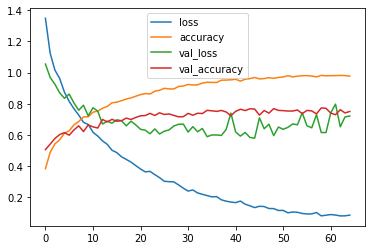

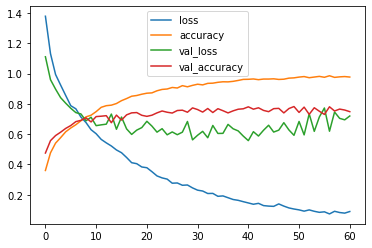

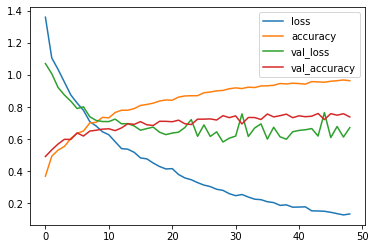

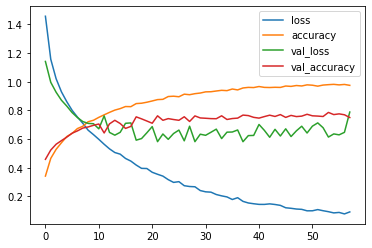

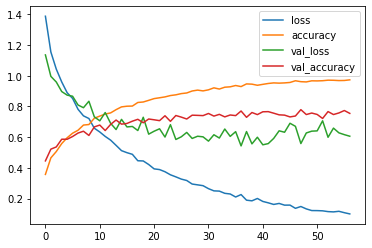

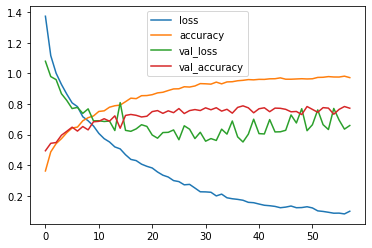

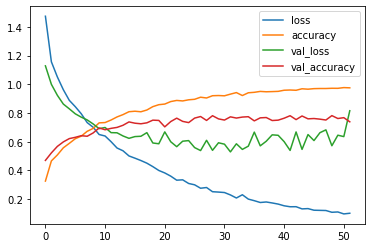

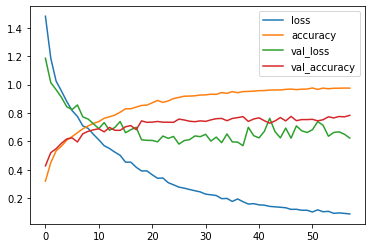

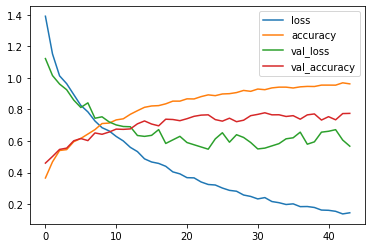

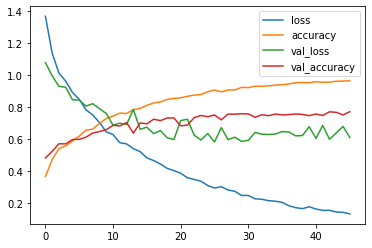

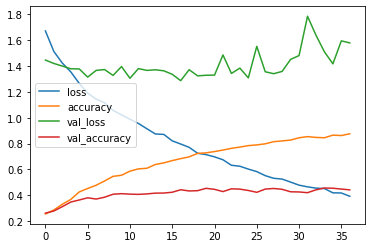

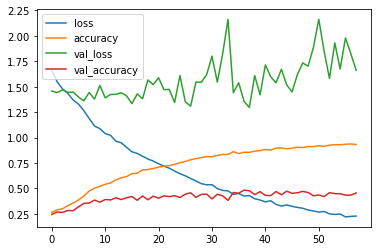

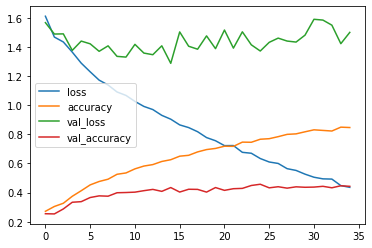

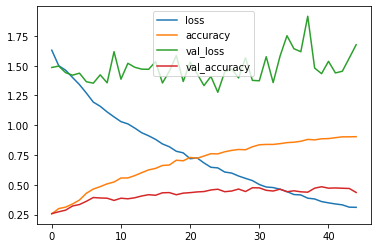

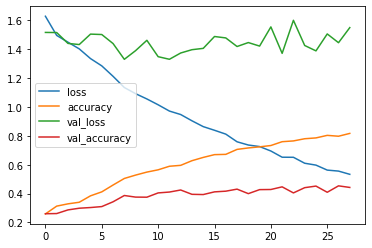

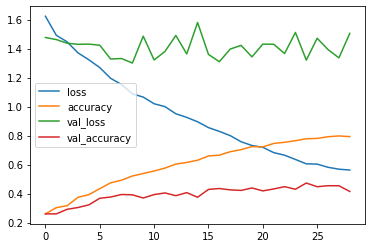

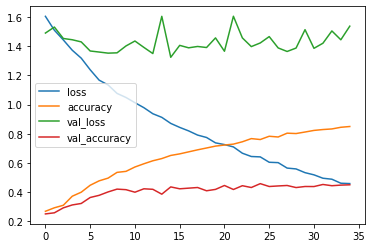

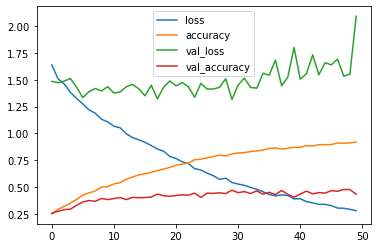

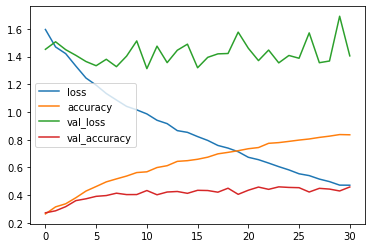

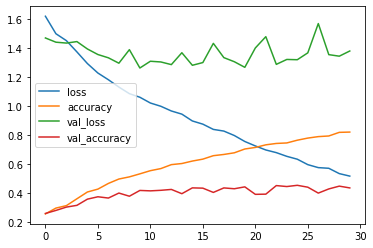

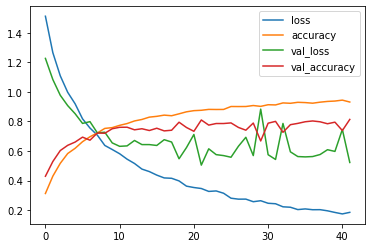

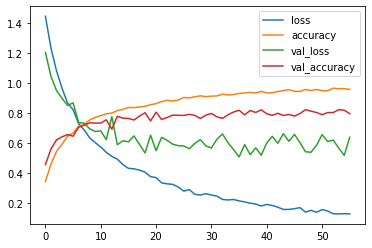

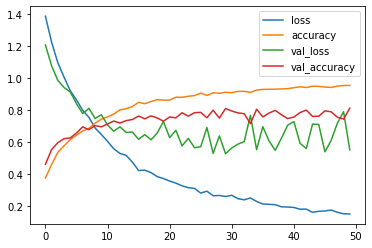

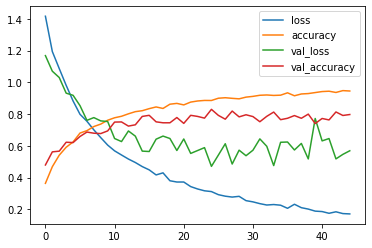

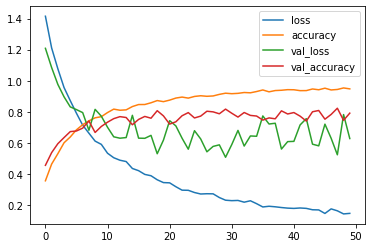

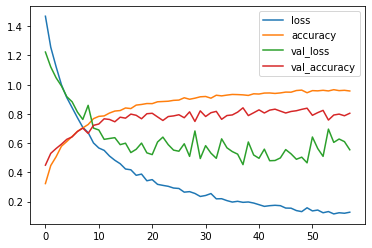

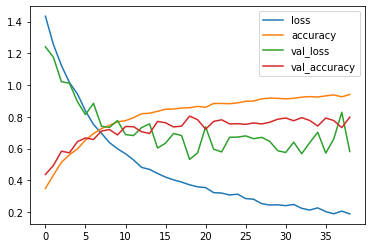

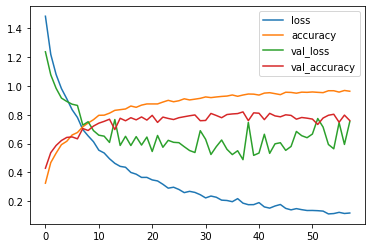

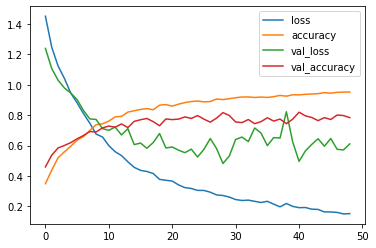

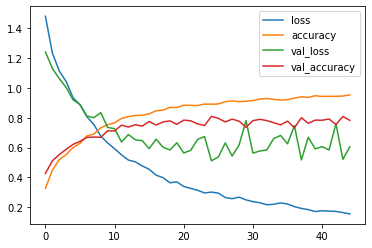

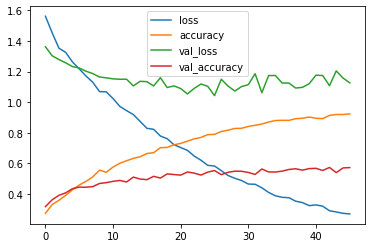

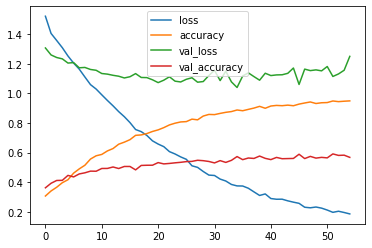

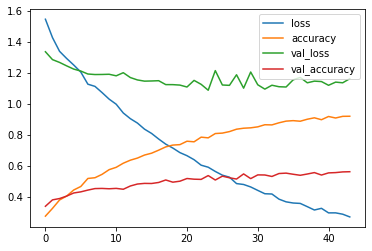

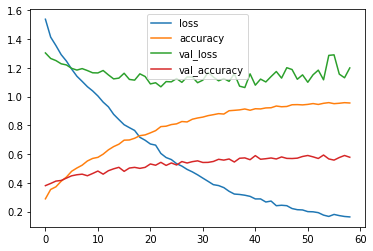

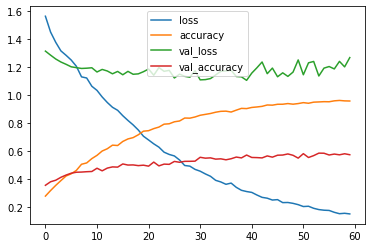

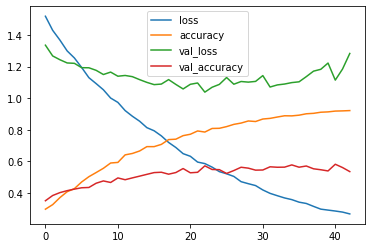

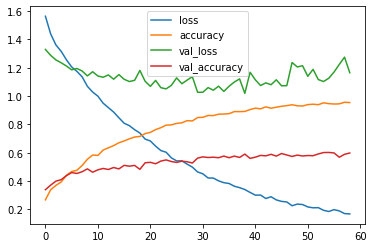

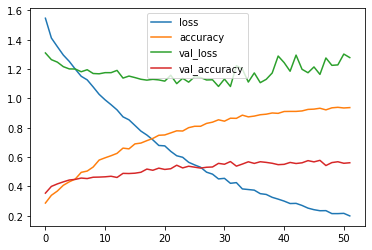

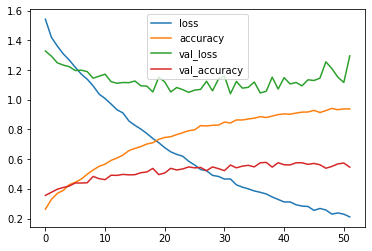

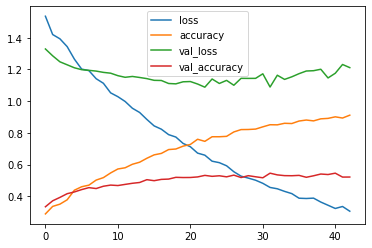

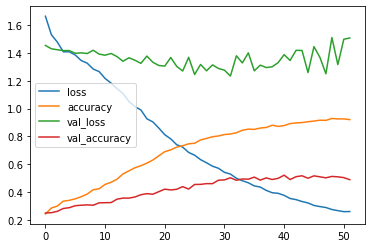

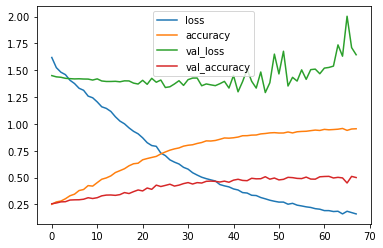

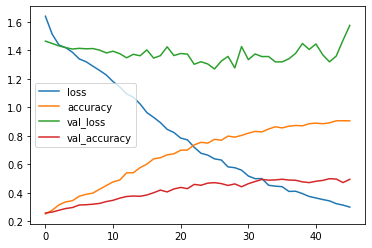

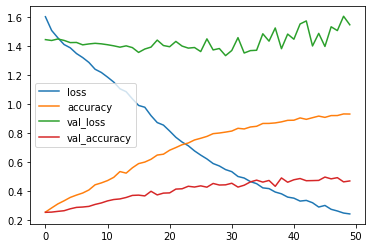

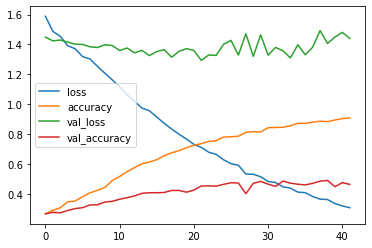

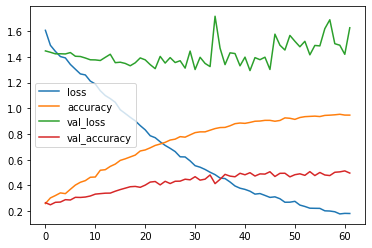

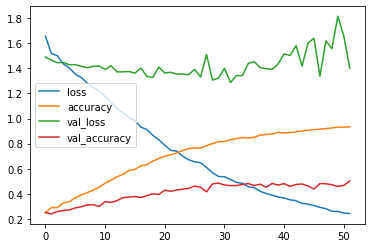

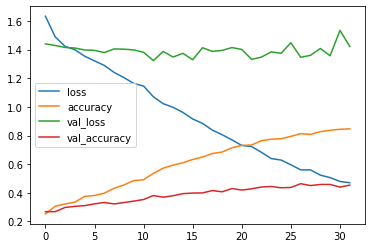

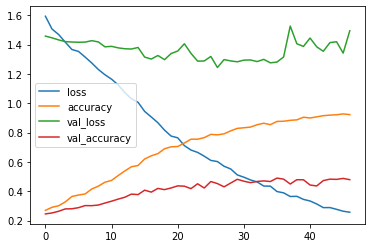

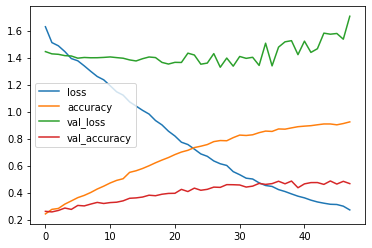

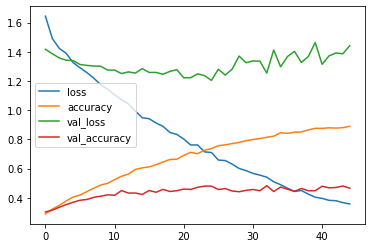

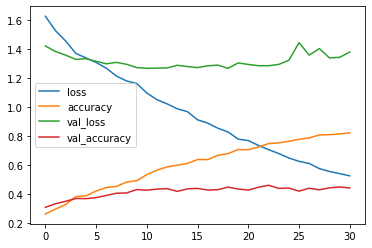

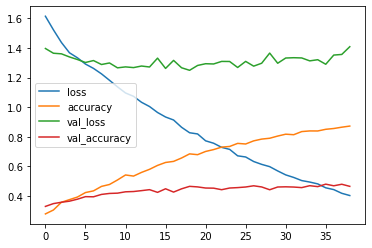

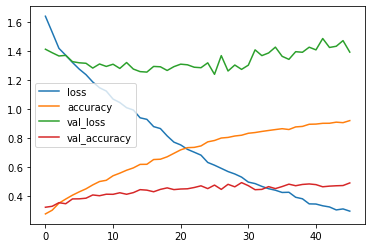

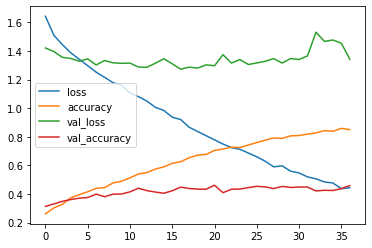

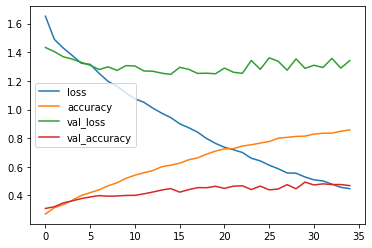

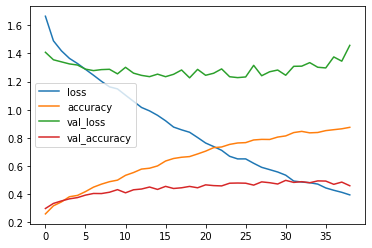

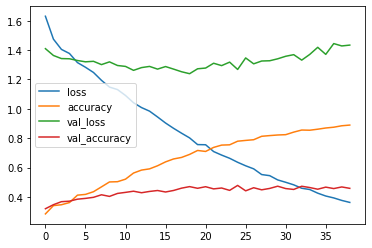

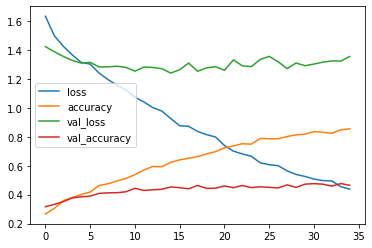

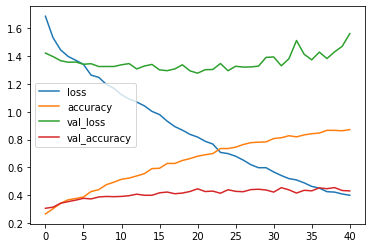

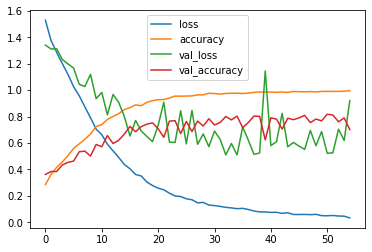

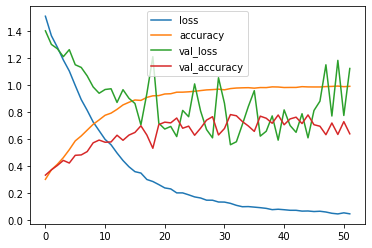

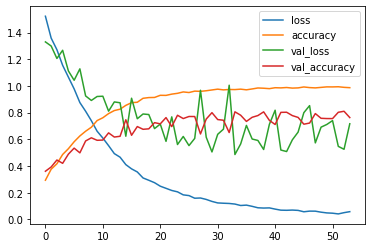

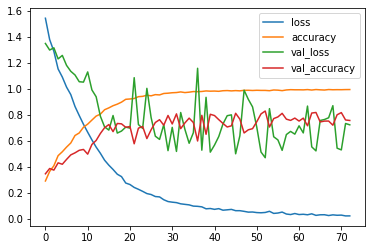

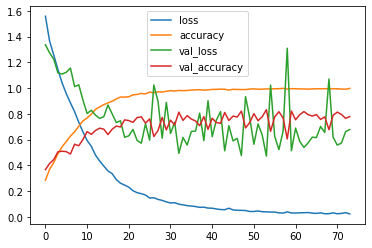

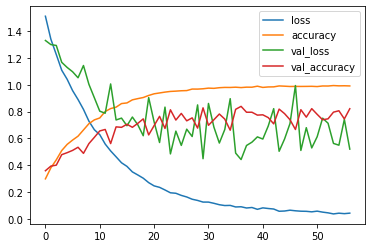

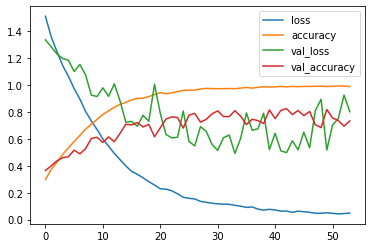

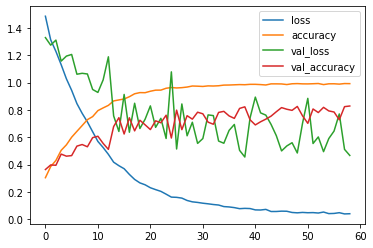

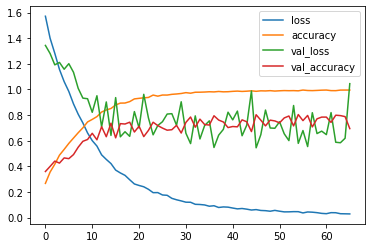

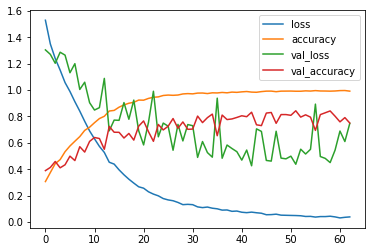

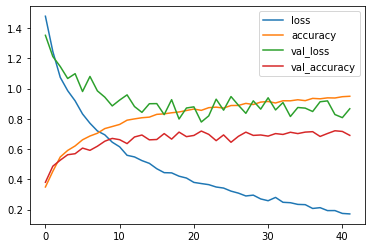

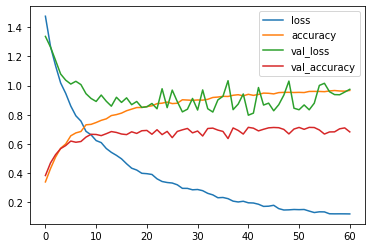

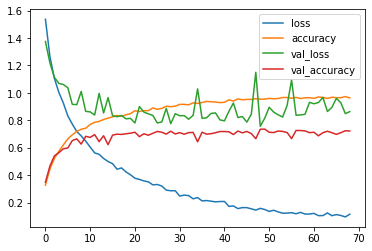

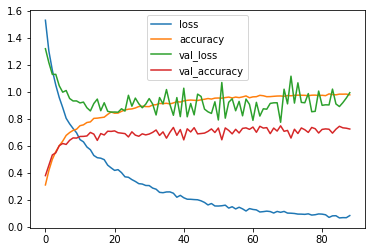

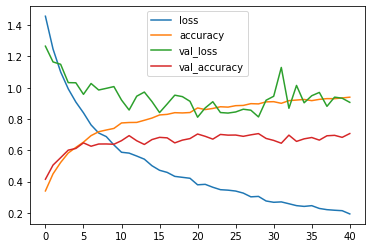

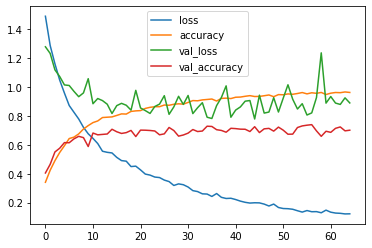

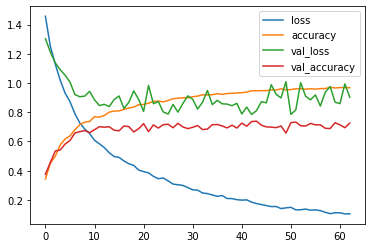

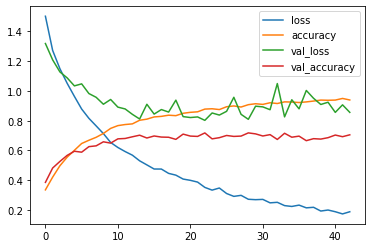

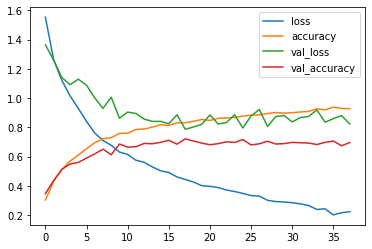

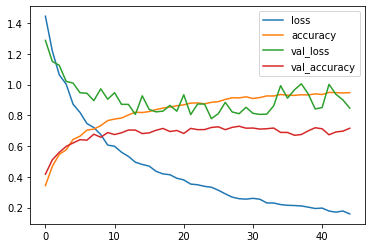

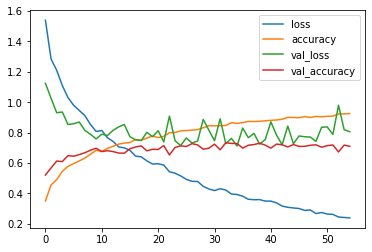

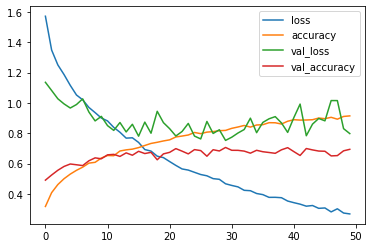

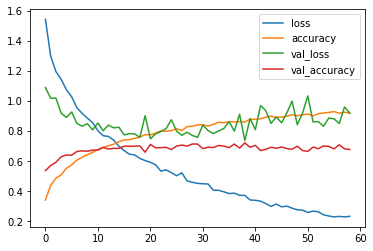

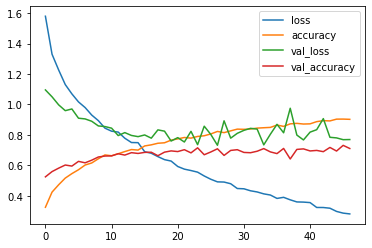

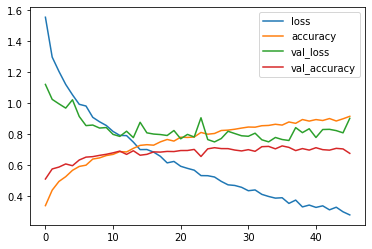

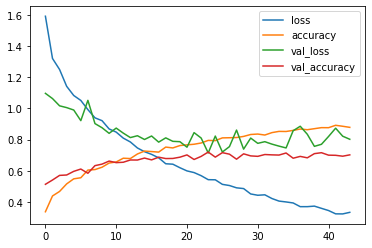

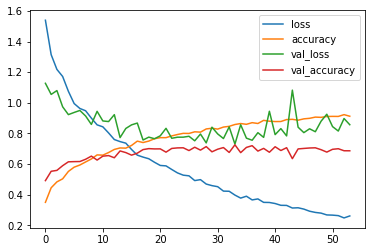

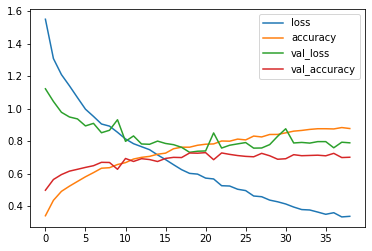

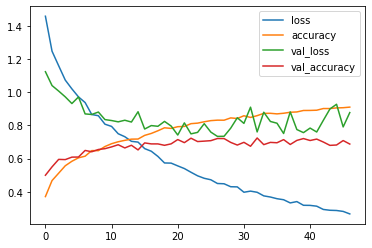

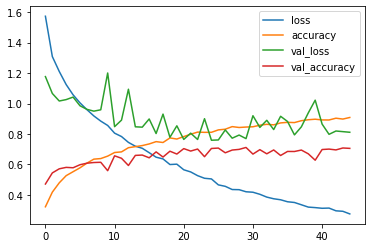

In [25]:
###Loop to train 10 models for each subject and obtain the classification accuracies
accuracies = {}
for i in range(9):
    accuracies[str(i+1)] = []
print(accuracies)

for subject in accuracies:
    xT, yT= create_4sec_data(int(subject),'T')
    xE, yE= create_4sec_data(int(subject),'E')
    x_train, y_train = filt_and_seg(xT,yT, 500, 0.90)
    x_val, y_val = filt_and_seg(xE,yE, 500, 0.90)
    y_cat_train = to_categorical(y_train)
    y_cat_val = to_categorical(y_val)
    for test in range(10):
        model = build_model()
        early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        model.fit(x_train,y_cat_train, epochs = 400, validation_data=(x_val,y_cat_val), callbacks = [early_stop])
        metrics = pd.DataFrame(model.history.history)
        metrics.plot()

        predictions = model.predict_classes(x_val)

        print(classification_report(y_val,predictions))

        print(confusion_matrix(y_val,predictions))
        perf = model.evaluate(x_val, y_cat_val)
        accuracies[subject].append(perf[1])

        
    

In [26]:
###Classification accuracies of 10 models trained for each subject's data
accuracies

{'1': [0.7651515007019043,
  0.7799873948097229,
  0.7462121248245239,
  0.7670454382896423,
  0.7698863744735718,
  0.7878788113594055,
  0.7733585834503174,
  0.7743055820465088,
  0.7657828330993652,
  0.75],
 '2': [0.44286617636680603,
  0.47727271914482117,
  0.43465909361839294,
  0.46243685483932495,
  0.3863636255264282,
  0.3914141356945038,
  0.4352903962135315,
  0.469696968793869,
  0.43339645862579346,
  0.4204545319080353],
 '3': [0.809974730014801,
  0.8175504803657532,
  0.8087121248245239,
  0.8298611044883728,
  0.8178661465644836,
  0.8415403962135315,
  0.8046085834503174,
  0.8197600841522217,
  0.8162878751754761,
  0.8090277910232544],
 '4': [0.5530303120613098,
  0.5726010203361511,
  0.5372474789619446,
  0.5735479593276978,
  0.5707070827484131,
  0.5719696879386902,
  0.5899621248245239,
  0.5697600841522217,
  0.5602903962135315,
  0.5318813323974609],
 '5': [0.5022096037864685,
  0.5078914165496826,
  0.4722222089767456,
  0.44381314516067505,
  0.453282833

In [28]:
###Obtain the best accuracies achieved for each subject
best_accuracies = []
for subject in accuracies:
    best_accuracies.append(max(accuracies[subject]))
    

In [29]:
best_accuracies

[0.7878788113594055,
 0.47727271914482117,
 0.8415403962135315,
 0.5899621248245239,
 0.5078914165496826,
 0.4804292917251587,
 0.839330792427063,
 0.747474730014801,
 0.7275883555412292]

In [32]:
###Mean classification accuracy of best models for all subjects
np.mean(best_accuracies)

0.6665965153111352